# AI 감정 인식 모델 평가 (엄밀한 검증)

이 노트북은 **Data Leakage(데이터 유출)**를 방지하기 위해, 
학습에 전혀 사용되지 않은 **`c:\Users\ldy34\Desktop\Face\video\Validation`** 폴더의 데이터를 사용하여 모델을 검증합니다.

**이전 99% 의혹 해결:**
- 이전 99% 정확도는 Video Frame의 유사성으로 인한 과대평가였습니다.
- 이제는 완전히 새로운 인물/영상의 데이터로 **진짜 실력**을 확인합니다.

**확인할 지표:**
- **Accuracy**: 새로운 데이터에 대한 정확도
- **Precision, Recall**: 특히 **불안(Anxious)**을 얼마나 잘 찾아내는지 (Recall)
- **Confusion Matrix**: 오답 분석

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import glob
import zipfile
import cv2
import mediapipe as mp
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# 외부 모듈 함수
from data_loader import process_single_image

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ============================
# 모델 구조 정의 (ResNet)
# ============================

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.block(x)

class ResidualEmotionNet(nn.Module):
    def __init__(self, input_size, hidden_dim=512):
        super(ResidualEmotionNet, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        )
        
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        self.res_block3 = ResidualBlock(hidden_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        return self.classifier(self.res_block3(self.res_block2(self.res_block1(self.input_layer(x)))))

In [3]:
# ============================
# [핵심] Validation 데이터 로드
# ============================
BASE_DIR = r"c:\Users\ldy34\Desktop\Face\video"
VAL_DIR = os.path.join(BASE_DIR, "Validation")  # Training 아님!
NUM_WORKERS = os.cpu_count() or 4

def load_validation_data(max_samples=5000):
    if not os.path.exists(VAL_DIR):
        raise FileNotFoundError(f"Validation directory not found at: {VAL_DIR}")

    zip_files = glob.glob(os.path.join(VAL_DIR, "*.zip"))
    print(f"Found {len(zip_files)} VALIDATION zip files.")
    
    if len(zip_files) == 0:
        print("[Warning] Validation 폴더에 zip 파일이 없습니다!")
        return np.array([]), np.array([])

    data_list = []
    for zip_path in zip_files:
        filename = os.path.basename(zip_path)
        # 파일명 규칙에 따라 라벨링
        if "중립" in filename or "Neutral" in filename:
            label = 0
        elif "불안" in filename or "Anxiety" in filename:
            label = 1
        else:
            continue
            
        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                file_list = [f for f in z.namelist() if f.lower().endswith(('.jpg', '.png'))]
                use_count = min(len(file_list), max_samples)
                
                # Validation은 골고루 뽑기 위해 전체에서 간격두고 샘플링
                indices = np.linspace(0, len(file_list)-1, use_count, dtype=int)
                target_files = [file_list[i] for i in indices]

                for img_name in target_files:
                    with z.open(img_name) as f:
                        data_list.append((f.read(), label))
        except Exception as e:
            print(f"Error reading {zip_path}: {e}")
    
    print(f"Loading {len(data_list)} validation images...")
    
    X, y = [], []
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(tqdm(executor.map(process_single_image, data_list), total=len(data_list), desc="Extracting Landmarks"))
        for res in results:
            if res is not None:
                X.append(res[0])
                y.append(res[1])
                
    return np.array(X), np.array(y)

In [4]:
# 1. Validation 데이터 로드
X_val, y_val = load_validation_data(max_samples=2000) # ZIP별 2000개씩

if len(X_val) == 0:
    print("데이터 로드 실패. 경로를 확인해주세요.")
else:
    # Tensor 변환
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)

    val_dataset = TensorDataset(X_val_t, y_val_t)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    print(f"\nvalidation Set Size: {len(X_val)} samples")

Found 12 VALIDATION zip files.
Loading 4000 validation images...


Extracting Landmarks: 100%|██████████| 4000/4000 [00:52<00:00, 75.81it/s] 



validation Set Size: 4000 samples


In [5]:
# 2. 모델 가중치 로드
MODEL_PATH = 'emotion_resnet_best.pth'

if len(X_val) > 0:
    model = ResidualEmotionNet(input_size=X_val.shape[1]).to(device)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH))
        model.eval()
        print("Model weights loaded.")
    else:
        print(f"Warning: Model file '{MODEL_PATH}' not found.")

Model weights loaded.


C:\Users\ldy34\AppData\Local\Temp\ipykernel_24460\453389832.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]c:\Users\ldy34\Desktop\Face\.venv\Lib\site-packages\torch\nn\modules\linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
Predicting: 100%|██████████| 32/32 [00:00<00:00, 104.14it/s]



               FINAL VALIDATION REPORT (STRICT)
              precision    recall  f1-score   support

     Neutral       0.85      0.84      0.85      2000
     Anxious       0.84      0.86      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



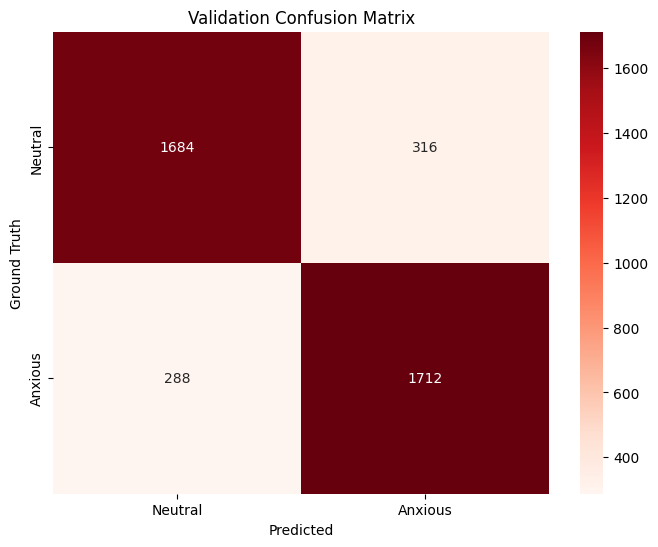

In [6]:
# 3. 평가 및 리포트 (True Performance)
if len(X_val) > 0:
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_b, y_b in tqdm(val_loader, desc="Predicting"):
            X_b = X_b.to(device)
            outputs = model(X_b)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(y_b.numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\n" + "="*60)
    print("               FINAL VALIDATION REPORT (STRICT)")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=['Neutral', 'Anxious']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=['Neutral', 'Anxious'], 
                yticklabels=['Neutral', 'Anxious'])
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Validation Confusion Matrix')
    plt.show()